Relevant Feature Extraction with SHAP
===

Avicenna uses a pattern matching approach to learn and relations between input elements. Matching all input elements (features) and assosiating their relation with the program behavior is not feasible. Thus, **Avicenna** uses a machine learning model to differentiate between passing and failing inputs (based on the input properties) and then uses [SHAP]() to extract the input elements that have the highest influence on the prediction outcome.

In the following notebook, we will demonstrate how **Avicenna** extracts the most important input elements that are most likely to cause the failure.

#### Example Subject

We use our sample calculator subject to illustrate Avicenna's capabilities. Please refere to the other notebooks, like [calculator.ipynb](./calculator.ipynb), for an in-depth walkthrough of the calculator subject.

In [1]:
from avicenna_formalizations.calculator import grammar, oracle, initial_inputs

In [2]:
for inp in initial_inputs:
    print(inp.ljust(20), oracle(inp))

cos(10)              PASSING
sqrt(28367)          PASSING
tan(-12)             PASSING
sqrt(-900)           FAILING


In [3]:
from fuzzingbook.Parser import EarleyParser, tree_to_string

parser = EarleyParser(grammar)
for inp in initial_inputs:
    for tree in parser.parse(inp):
        assert tree_to_string(tree) == inp

## Constructing Feature Vectors

In [4]:
from avicenna.input.input import Input

In [5]:
test_inputs = set()
for inp in initial_inputs:
    test_inputs.add(
        Input.from_str(grammar, inp, oracle=oracle(inp))
    )

for inp in test_inputs:
    print(str(type(inp)).ljust(40), str(inp).ljust(20), inp.oracle)

<class 'avicenna.input.input.Input'>     sqrt(-900)           FAILING
<class 'avicenna.input.input.Input'>     cos(10)              PASSING
<class 'avicenna.input.input.Input'>     tan(-12)             PASSING
<class 'avicenna.input.input.Input'>     sqrt(28367)          PASSING


#### Collecting Features

In [8]:
from avicenna.features.feature_collector import GrammarFeatureCollector, FeatureVector
from avicenna.features.features import NumericFeature

collector = GrammarFeatureCollector(grammar, feature_types=[NumericFeature])

In [9]:
feature_vector: FeatureVector = collector.collect_features(
    Input.from_str(grammar, "sqrt(-900)")
)

In [10]:
print(feature_vector)

sqrt(-900): {num(<onenine>): 9.0, num(<digit>): 0.0, num(<maybe_frac>): -inf, num(<digits>): 0.0, num(<number>): -900.0, num(<maybe_digits>): 0.0}


In [12]:
from avicenna.features.features import (
    ExistenceFeature,
    NumericFeature,
    LengthFeature,
    DerivationFeature,
)

features = [
    ExistenceFeature,
    NumericFeature,
    DerivationFeature,
    LengthFeature
]
collector = GrammarFeatureCollector(grammar, feature_types=features)
feature_vector: FeatureVector = collector.collect_features(
    Input.from_str(grammar, "sqrt(-900)")
)
print(feature_vector)

sqrt(-900): {exists(<start>): 1, exists(<arith_expr>): 1, exists(<function>): 1, exists(<number>): 1, exists(<maybe_minus>): 1, exists(<onenine>): 1, exists(<digit>): 1, exists(<maybe_digits>): 1, exists(<digits>): 1, exists(<maybe_frac>): 1, num(<onenine>): 9.0, num(<digit>): 0.0, num(<maybe_frac>): -inf, num(<digits>): 0.0, num(<number>): -900.0, num(<maybe_digits>): 0.0, exists(<start>&nbsp;->&nbsp;<arith_expr>): 1, exists(<arith_expr>&nbsp;->&nbsp;<function>(<number>)): 1, exists(<function>&nbsp;->&nbsp;sqrt): 1, exists(<function>&nbsp;->&nbsp;sin): 0, exists(<function>&nbsp;->&nbsp;cos): 0, exists(<function>&nbsp;->&nbsp;tan): 0, exists(<number>&nbsp;->&nbsp;<maybe_minus><onenine><maybe_digits><maybe_frac>): 1, exists(<maybe_minus>&nbsp;->&nbsp;): 0, exists(<maybe_minus>&nbsp;->&nbsp;-): 1, exists(<onenine>&nbsp;->&nbsp;1): 0, exists(<onenine>&nbsp;->&nbsp;2): 0, exists(<onenine>&nbsp;->&nbsp;3): 0, exists(<onenine>&nbsp;->&nbsp;4): 0, exists(<onenine>&nbsp;->&nbsp;5): 0, exists(<

In [13]:
for inp in test_inputs:
    inp.update_features(collector.collect_features(inp))
    #print(inp.features)

## Using _SHAP_ to Learn Most Influential Input Propterties

In [15]:
from avicenna.features import feature_extractor

In [16]:
feature_learner = feature_extractor.DecisionTreeRelevanceLearner(
    grammar, prune_parent_correlation=False
)
(
    relevant_features,
    correlating_features,
    excluded_features,
) = feature_learner.learn(test_inputs)

In [17]:
print(relevant_features)

{num(<number>)}


In [18]:
feature_learner = feature_extractor.SHAPRelevanceLearner(
    grammar,
    classifier_type=feature_extractor.GradientBoostingTreeRelevanceLearner,
    top_n=2,
)

In [19]:
rel, corr, ex = feature_learner.learn(test_inputs)

In [20]:
from isla.fuzzer import GrammarFuzzer

fuzzer = GrammarFuzzer(grammar)

fuzzing_inputs = set()
for _ in range(100):
    inp = fuzzer.fuzz_tree()
    fuzzing_inputs.add(
        Input(inp, oracle(inp))
    )
for inp in fuzzing_inputs:
    inp.update_features(collector.collect_features(inp))

In [21]:
feature_learner = feature_extractor.SHAPRelevanceLearner(
    grammar,
    classifier_type=feature_extractor.GradientBoostingTreeRelevanceLearner,
    top_n=2,
    show_beeswarm_plot=True
)

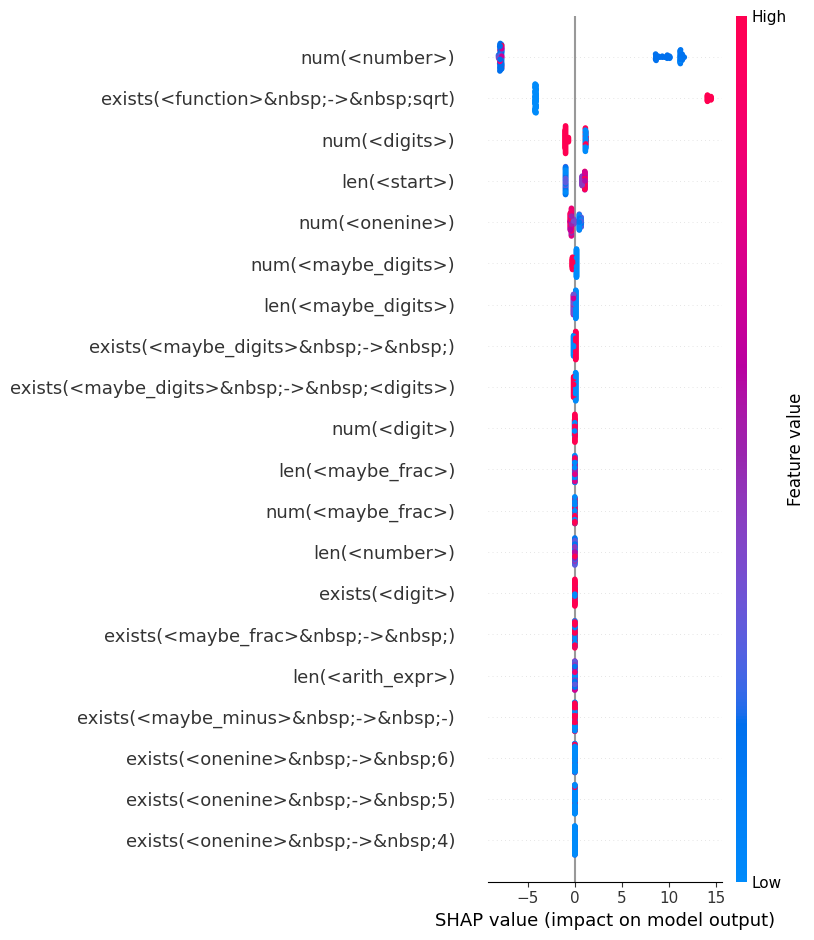

In [22]:
relevant_features, correlating_features, _ = feature_learner.learn(fuzzing_inputs)

In [23]:
relevant_features

{exists(<function>&nbsp;->&nbsp;sqrt), num(<number>)}

In [24]:
correlating_features

{len(<function>)}